In [11]:
%matplotlib inline


import pandas as pd
import numpy as np
import tensorflow as tf
import pickle
import threading
from math import floor
#import Test
import time
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import FuncFormatter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import shuffle
from sklearn.cluster import KMeans
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool, freeze_support
from itertools import repeat

# SEQUENCE_LENGTH = 8
# PREDICTION_DELTA = 4
VIDEO_LEN_LIMIT = 50

MIN_VIEWS = 100 #1000 ?

BATCH_SIZE = 10
TRAIN_STEPS = 80000
LEARNING_RATE = 2e-3
STABLE_DELTA = 0.69 # 2 views
THREADS_COUNT = 2


# fig, ax = plt.subplots()
# plt.figure(figsize=(12, 5))
# ax.xaxis.set_major_formatter(FormatStrFormatter('%.5f'))


def rolling_window(a, window, lablesShift):
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)

    data = np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)
    lables = a[window - 1 + lablesShift::1]
    return data[:-lablesShift], lables


def LoadData(name):
    df = pd.read_csv('data/' + name + '.csv',
                     index_col=['date'],
                     dtype={"video_id": object, "views": np.float64},
                     parse_dates=['date'])
    return df


def GetNextBatch(inputs, lables, batchId):
    batchId = batchId % len(inputs)
    startIndex = batchId * BATCH_SIZE
    endIndex = (batchId + 1) * BATCH_SIZE
    if (len(inputs) < endIndex):
        startIndex = 0
        endIndex = BATCH_SIZE

    return (inputs[startIndex:endIndex], lables[startIndex:endIndex])


def DfToList(df):
    listOfVideoViews = list(df.groupby('video_id')['views'].apply(pd.DataFrame.as_matrix))
    return listOfVideoViews

def ExtractSequenes(listOfVideoViews, seqLen, predDelta, minLen, maxLen):
    if (not minLen):
        minLen = 0

    if (not maxLen):
        maxLen = 10e+10
    
    koefs = []
    datas = []
    lables = []
    maxV = 0
    maxI = 0

    for i in range(len(listOfVideoViews)):
        s = listOfVideoViews[i]
        if (len(s) > minLen and len(s) < maxLen):

            daysToRemove = 0
            passed = False

            for j in range(len(s)):
                if (s[j] > 20):
                    daysToRemove = j
                    passed = True
                    break

            if (passed and (len(s) - daysToRemove > minLen)):
                realDaysToRemove = max(daysToRemove, 30)
                data, lable = rolling_window(s[realDaysToRemove:], window=seqLen, lablesShift=predDelta)
                datas.extend(data)
                lables.extend(lable)

    datas_res = np.log(datas)
    lables_res = np.log(lables)

    datas_res = np.clip(datas_res, a_min = STABLE_DELTA, a_max = 99999999999)
    lables_res = np.clip(lables_res, a_min = STABLE_DELTA, a_max = 99999999999)
    
    return datas_res, lables_res


globW0 = []
globWL = []
shifts = []

def TrainModel(train_inputs, train_lables, test_inputs, test_lables, SEQUENCE_LENGTH):

    X = tf.placeholder("float", shape=(None, SEQUENCE_LENGTH), name="Inputs")  # , COLUMNS_COUNT
    Y = tf.placeholder("float", shape=(None, 1), name="Outputs")

    W = tf.Variable(tf.ones([SEQUENCE_LENGTH, 1]), name="weight")  # COLUMNS_COUNT

    pred = tf.reduce_sum(tf.matmul(X, W), axis=1)
    loss = tf.reduce_mean(tf.square(pred / Y - 1))
    grads = tf.gradients(loss, [W])[0]

    optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
    train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

    sess = tf.Session()
    sess.run(init)
    losses = []

    for step in range(TRAIN_STEPS):
        training_data, lables = GetNextBatch(train_inputs, train_lables, step)
        inputs = np.reshape(training_data, (BATCH_SIZE, SEQUENCE_LENGTH))
        output = np.reshape(lables, (BATCH_SIZE, 1))

        _, curLoss = sess.run([train, loss], feed_dict={X: inputs, Y: output})
        losses.append(curLoss)

        if (step % 9000 == 0):
            mn = np.mean(losses[len(losses) - 9000: len(losses)])
            #print("loss: ", mn)
            #print("W = ", sess.run(W))

    test_lables = np.reshape(test_lables, (len(test_lables), 1))
    predictTest = sess.run(pred, feed_dict={X: test_inputs})

    originalPredicted = np.exp(np.array(predictTest))

    # if (absNorms is not None):
    #     originalPredicted *= absNorms

    originalTestOutputs = np.exp(test_lables.ravel())  # Why exp here ???!!
    rse = ((originalPredicted / originalTestOutputs) - 1) ** 2
    mapeAr = abs(1 - originalPredicted / originalTestOutputs)
    
    curW = sess.run(W)
    print("W0 = ", curW[0][0])
    globW0.append(curW[0][0])
    print("WL = ", curW[-1][0])
    globWL.append(curW[-1][0])
    
#     tr_inputs = np.reshape(train_inputs, (len(train_inputs), SEQUENCE_LENGTH))
#     tr_output = np.reshape(train_lables, (len(train_lables), 1))
#     trainLoss = sess.run(loss, feed_dict={X: tr_inputs[:30000], Y: tr_output[:30000]})
#     print("train loss", trainLoss)

#     tst_inputs = np.reshape(test_inputs, (len(test_inputs), SEQUENCE_LENGTH))
#     tst_output = np.reshape(test_lables, (len(test_lables), 1))
#     testLoss = sess.run(loss, feed_dict={X: tst_inputs[:30000], Y: tst_output[:30000]})
#     print("testLoss loss", testLoss)

#     predictTrain = sess.run(pred, feed_dict={X: tr_inputs})
#     originalTrainPredicted = np.exp(np.array(predictTrain))
#     originalTrainOutputs = np.exp(train_lables.ravel())
#     mapeAr_train = abs(1 - originalTrainPredicted / originalTrainOutputs)
#     print("mapeAr_train mean", mapeAr_train.mean())

#     mn = pd.rolling_mean(np.array(losses), 500)
#     plt.plot(mn[500:])
#     plt.show()

    return rse.mean(), rse.var(), mapeAr.mean(), mapeAr.var()


def ExtractNormilizedSequences(listOfVideoViews, seqLen, minLen, maxLen):
    if (not minLen):
        minLen = 0

    if (not maxLen):
        maxLen = 10e+10

    datas = []
    lables = []
    for s in listOfVideoViews:
        if (len(s) > minLen and len(s) < maxLen):
            data = np.array(s[:seqLen])
            maxData = np.max(data)  # data[seqLen - 1]
            if (maxData > 0):
                data = data / maxData
                datas.append(data)

    return np.array(datas)


def TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLength, lableShift, minLimit, maxLimit):
    id = threading.current_thread()
    print("Hi from thread id: ", id)
    train_inputs, train_lables = ExtractSequenes(listOfTrainVideoViews, seqLength, lableShift, minLimit, maxLimit)
    test_inputs, test_lables = ExtractSequenes(listOfTestVideoViews, seqLength, lableShift, minLimit, maxLimit)
    rseMean, rseVar, mapeMean, mapeVar = TrainModel(train_inputs, train_lables, test_inputs, test_lables, seqLength)
    print("Complited: lableShift = ", lableShift)
    shifts.append(lableShift)
    return rseMean, rseVar, mapeMean, mapeVar

def GetRegrouppedViews(trainDf, testDf):
    return DfToList(trainDf), DfToList(testDf)


def AddTrend(x, y):
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.plot(x, p(x), "r--")


def Plot(dataL, step=1):
    rseMean, rseVar, mapeMean, mapeVar = zip(*dataL)
    # calc the trendline
    x = np.arange(start=0, stop=len(mapeMean), step=step)
    y = mapeMean
    plt.title('MAPE mean')
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    AddTrend(x, y)
    plt.plot(x, y)
    plt.show()

    x = np.arange(len(mapeVar))
    y = mapeVar
    plt.title('MAPE var')
    AddTrend(x, y)
    plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
    plt.plot(x, y)
    plt.show()

    minInd = np.argmin(mapeMean)

    print("Min at index: {}; val: {}%".format(minInd, x[minInd] * 100.0))


def TestSeqLenPerf(listOfTrainVideoViews, listOfTestVideoViews, predDelta, minSeqLen, maxSeqLen, seqLenStep=1, minLimit=None,
                   maxLimit=None):
    dataL = []

    for seqLen in range(minSeqLen, maxSeqLen, seqLenStep):
        print("{} from {}".format(seqLen, maxSeqLen), end="\r")
        statsTuple = TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

    return dataL

def TestSeqPredDeltaPerf_old(listOfTrainVideoViews, listOfTestVideoViews, seqLen, maxPredDelta, predDeltaStep=1,
                         minLimit=None, maxLimit=None):
    dataL = []

    for predDelta in range(1, maxPredDelta, predDeltaStep):
        # print("{} from {}".format(predDelta, maxPredDelta), end="\r")
        print("{} from {}".format(predDelta, maxPredDelta))
        statsTuple = TestParams(listOfTrainVideoViews, listOfTestVideoViews, seqLen, predDelta, minLimit, maxLimit)
        dataL.append(statsTuple)

    return dataL

def TestSeqPredDeltaPerf(listOfTrainVideoViews, listOfTestVideoViews, seqLen, minPredDelta,
                         maxPredDelta, predDeltaStep, minLimit=None, maxLimit=None):
    with ThreadPool(THREADS_COUNT) as pool:
        predDeltas = range(minPredDelta, maxPredDelta, predDeltaStep)
        args = zip(repeat(listOfTrainVideoViews), repeat(listOfTestVideoViews),
                   repeat(seqLen), predDeltas, repeat(minLimit), repeat(maxLimit))
        results = pool.starmap(TestParams, args)

    return results

In [3]:
trainDf = LoadData('train')
testDf = LoadData('validation')

In [4]:
trainViewsD, testViewsD = GetRegrouppedViews(trainDf, testDf)

In [ ]:
start = time.time()

# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
dSeqPred = TestSeqPredDeltaPerf(trainViewsD, testViewsD, seqLen = 26, minPredDelta = 1,
                                    maxPredDelta = 3, predDeltaStep = 1, minLimit = 60, maxLimit = None)

end = time.time()
print(end - start)

In [12]:
start = time.time()

# Test daily prediction prefomance up to one year using last 26 days. For videos with history more then 1 year.
dSeqPred = TestSeqPredDeltaPerf_old(trainViewsD, testViewsD, seqLen = 26, 
                                    maxPredDelta = 130, predDeltaStep = 30, minLimit = 60, maxLimit = None)

end = time.time()
print(end - start)

1 from 130
Hi from thread id:  <_MainThread(MainThread, started 140655432369920)>
W0 =  0.0373206
WL =  0.0404292
Complited: lableShift =  1
31 from 130
Hi from thread id:  <_MainThread(MainThread, started 140655432369920)>
W0 =  0.0338989
WL =  0.043915
Complited: lableShift =  31
61 from 130
Hi from thread id:  <_MainThread(MainThread, started 140655432369920)>
W0 =  0.031642
WL =  0.0463956
Complited: lableShift =  61
91 from 130
Hi from thread id:  <_MainThread(MainThread, started 140655432369920)>
W0 =  0.0299452
WL =  0.0482007
Complited: lableShift =  91
121 from 130
Hi from thread id:  <_MainThread(MainThread, started 140655432369920)>
W0 =  0.0279386
WL =  0.0495539
Complited: lableShift =  121
174.24866008758545


[0.036757261, 0.03864884, 0.039859638, 0.041516297]


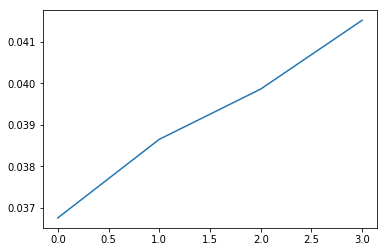

In [10]:
print(globWL)
plt.plot(globWL)

[ 1.          0.90831721  0.84784436  0.8023771   0.74861121]


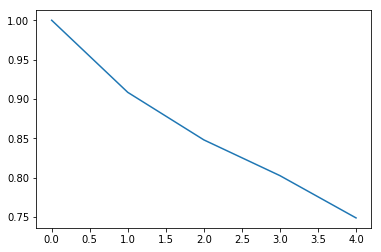

In [13]:
fw = np.array(globW0)
fw /= fw[0]
print(fw)
plt.plot(fw)



In [ ]:
start = time.time()

statsTuple4 = TestParams(trainViewsD, testViewsD, 26, 255-1, minLimit = 360, maxLimit = None)
print(statsTuple4)

end = time.time()
print(end - start)

In [ ]:
rseMean, rseVar, mapeMean, mapeVar = zip(*dSeqPred)
print(mapeMean[56])
# plt.plot(mapeMean)
# plt.show()

In [ ]:
statsTuple_1d = TestParams(trainViewsD, testViewsD, 1, 8 * 30, minLimit = 360, maxLimit = None)
print(statsTuple_1d)

In [ ]:
rseMean, rseVar, mapeMean, mapeVar  = zip(*dSeqPred)
ind = np.argmin(mapeMean)
print(ind)
print(mapeMean[ind])
print(rseMean)